In [7]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

import pickle

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
class uji(): 
    def __init__(self,data): 
        df0 = pd.read_csv('../data2/uji%snorm.csv'%data, delimiter= ",", header=None)
        df0=df0.fillna(0)
        self.com=df0[0]
        self.prot=df0[1282]
        self.x =df0.drop([0,1282], axis=1)
        df0[1300]=0
        
        self.y=df0[1300]
        self.dt=data
class latih(): 
    def __init__(self,data): 
        df = pd.read_csv("../data2/%s.csv"%data, delimiter=',')
        df.head()
        self.X = df.drop(['0','1282','label'], axis=1)
        self.Y = df['label']
        self.dt=data
def dtuji(data): 
    return uji(data) 
def dtlatih(data): 
    return latih(data) 

dtf =dtuji('mbafika') #dtf.com, dtf.prot, dtf.x, dtf.y, dtf.dt
dtl =dtuji('mbalinda') #dtl.com, dtl.prot, dtl.x, dtl.y dtl.dt
df= dtlatih('latih_parted') #df.X,df.Y,df.dt

#RF

In [9]:
def rf(n,m,df):
    #random_grid = {'n_estimators': [n],
   #                #'max_depth': max_depth,
    #               'bootstrap': [True],
    #               'max_samples':[m],}
    rf = BaggingClassifier(n_estimators=n,bootstrap=True,max_samples=m,base_estimator=DecisionTreeClassifier())
    rf = GridSearchCV(rf, random_grid, n_jobs=-1, cv=2)
    rf.fit(df.X, df.Y)
    filename = '../data2/model2/rf_{0}n_{1}m_cv'.format(n,m)
    pickle.dump(rf, open(filename, 'wb'))
    return rf

#MLP

In [120]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

Using TensorFlow backend.


In [147]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(640, input_dim=1281, init='normal', activation='relu'))
    model.add(Dense(320, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [155]:
def mlp(n,m,df):
    mlp = MLPClassifier(max_iter=1000, batch_size=128,hidden_layer_sizes=(640,320,),activation= 'relu',
                        solver= 'adam', alpha= 0.5,learning_rate= 'constant')
    model = Sequential()
    model.add(Dense(640, input_dim=1281, init='uniform', activation='relu'))
    model.add(Dense(320, init='uniform', activation='relu'))
    model.add(Dense(1, init='uniform', activation='sigmoid'))
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', KerasClassifier(build_fn=create_model, nb_epoch=100, batch_size=128, verbose=0,class_weight="balanced")))
    pipeline = Pipeline(estimators)
#    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#    results = cross_val_score(pipeline, df.X, df.Y, cv=kfold)
#    print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
#    parameter_space = {
#        'hidden_layer_sizes': [(640,320,)],
#        'activation': ['relu'],
#        'solver': ['adam'],
#        'alpha': [0.5],
#        'learning_rate': ['constant'],
#    }
    mlp.fit(df.X, df.Y,class_weight="balanced")
    filename = '../data2/model/mlp_{0}n_{1}m_balanced'.format(n,m)
    pickle.dump(mlp, open(filename, 'wb'))
    return mlp

In [156]:
fitn2pred(mlp,10,100,0.5,df,dtf,dtl)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(640, input_dim=1281, activation="relu", kernel_initializer="uniform")`
  """
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(320, activation="relu", kernel_initializer="uniform")`
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
  import sys


n = 10
m = 100
model file : mlp_10n_100m_balanced
Parameters used: {'activation': 'relu', 'alpha': 0.5, 'batch_size': 128, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (640, 320), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Accuracy: 0.9918806232170287
f1: 0.9727740986019131
precision: 0.9821693907875185
recall: 0.9635568513119533
roc_auc: 0.9802284385725358
Confusion matrix:
[[3859   12]
 [  25  661]]
Results on the train set:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3871
           1       0.98      0.96      0.97       686

    accuracy                           0.99      4557
   macro avg       0.99      0.98      0.9

In [133]:
#SVM

In [182]:
def svm(n,m,df):
    classifier0 = SVC(C=8.0, gamma=0.0078125,class_weight="balanced",probability=True)
    classifier0.fit(df.X, df.Y)
    filename = '../data2/model/svm_{0}n_{1}m_balanced'.format(n,m)
    pickle.dump(classifier0, open(filename, 'wb'))
    return classifier0

In [10]:
## Import Modules
import numpy as np
import pandas as pd
import os
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding cla

DATA OVERVIEW

Active file full dimensions (rows, columns):  (4557, 1281)


In [17]:


# Set the parameters by cross-validation

tuned_parameters = {'kernel': ['rbf'],
                    'gamma': [0.0078125],
                    'C': [8.0]}
def svm(n,m,df):
    classifier0 = SVC(C=8.0, gamma=0.0078125,class_weight="balanced",probability=True)
    classifier0.fit(df.X, df.Y)
    filename = '../data2/model/svm_{0}n_{1}m_balanced'.format(n,m)
    pickle.dump(classifier0, open(filename, 'wb'))
    return classifier0
##Add different measures for optimisation

scores = { 'roc_auc',  'accuracy','f1','precision', 'recall'}

###Fitting Models


clf = GridSearchCV(SVC(probability=True),tuned_parameters, cv=5,n_jobs=-1, scoring = score)
grid = clf.fit(X, y)
print("GridSearchCV Grid scores on development set (not on test set):")
print()



GridSearchCV Grid scores on development set (not on test set):



In [18]:
import pickle

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator BaggingClassifier from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.341 (+/-0.406) for {'C': 8.0, 'gamma': 0.0078125, 'kernel': 'rbf'}

Best parameters set found on development set:

{'C': 8.0, 'gamma': 0.0078125, 'kernel': 'rbf'}

ACCURACY REPORT

Accuracy of optimised SVC on test set: 86.38%

Detailed report for Test set measures:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1162
           1       0.92      0.82      0.86       206

    accuracy                           0.96      1368
   macro avg       0.94      0.90      0.92      1368
weighted avg       0.96      0.96      0.96      1368


AUC ROC REPORT

AUC score: 0.99


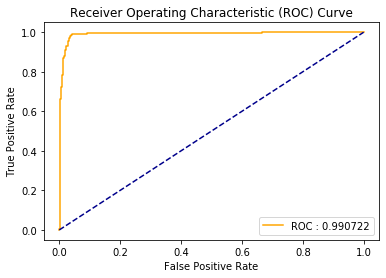

In [22]:

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    print()
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("ACCURACY REPORT")
    print()  
    print('Accuracy of optimised SVC on test set: {:.2f}%'.format(grid.score(X_test, y_test) * 100))
    #print('Old SVM Accuracy for reference : 67.2%')
    print()  
    print("Detailed report for Test set measures:")
    print()  
    y_true, y_pred = y_test, grid.predict(X_test)
    print(classification_report(y_true, y_pred))
    
###ROC Curve


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = grid.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='AUC = %f'%auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


print()
print("AUC ROC REPORT")
print()
print('AUC score: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probs)

plot_roc_curve(fpr, tpr)

In [25]:
def roccurve1(df,model)
    ## Load Data (Python conform)
    print("DATA OVERVIEW")
    print("\nActive file full dimensions (rows, columns): ", df.X.shape)

    ## Define Input/Output
    X = df.X
    y = df.Y

    #print("Chosen Input: ", X.columns.values)
    #print("Chosen Outpout:", y.name)

    ## Data splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
    grid = pickle.load(open('../data2/model/{0}'.format(model), 'rb'))
    ###ROC Curve
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    probs = grid.predict_proba(X_test)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)

    def plot_roc_curve(fpr, tpr):
        plt.plot(fpr, tpr, color='orange', label='ROC : %f'%auc)
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()


    print()
    print("AUC ROC REPORT")
    print()
    print('AUC score: %.2f' % auc)

    fpr, tpr, thresholds = roc_curve(y_test, probs)

    plot_roc_curve(fpr, tpr)

AttributeError: 'BaggingClassifier' object has no attribute 'cv_results_'